In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Layer, Embedding, LSTM, Dense, Input
import keras.backend as K
import re
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import classification_report
import sys
sys.path.append("../")
from model.attention import AttentionMecanism
warnings.filterwarnings('ignore')

The data we were used still has two main dimensions: tweets and labels. The tweets represent pure text collected from Twitter about ChatGPT, covering various topics and opinions shared by users. The labels associated with each tweet indicate the sentiment that the authors want to transmit in their messages, such as positive, negative, neutral. 

To access and explore the dataset, please follow this link: [ChatGPT-Tweets](https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis)

In [14]:
file_path = '../database/file.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


Text cleaning is an essential preprocessing step in sentiment analysis tasks. It involves removing irrelevant information and transforming the text into a consistent and standardized format, making it easier for machine learning models to understand and process the data. Here are some common text cleaning steps used in this notebook.

* Lowercasing: Convert the entire text to lowercase. This ensures that the model treats words with different cases (e.g., "happy" and "Happy") as the same, reducing vocabulary size and improving generalization.

* Removing special characters and punctuation: Eliminate symbols, emojis, and punctuation marks as they often don't contribute much to sentiment analysis and may add noise to the data.

* Removing numbers: Numerical values may not be relevant in sentiment analysis and can be removed from the text.

* Removing stop words: Common words like "the," "is," "a," etc., are generally removed as they don't carry significant sentiment information.

* Lemmatization or stemming: Reducing words to their base or root form helps in consolidating similar words and reducing the dimensionality of the data. Lemmatization is preferred over stemming as it generates meaningful words.

* Removing URLs and mentions: In sentiment analysis on social media data, URLs and user mentions (@username) are often removed as they don't contribute to sentiment but may add noise.

In [15]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def text_clean(text):
    
    #remove links | Remove Unicode characters | \\n | only alphabets
    #patter = re.compile(r'https?:\/\/.*[\r\n]*|[^\x00-\x7F]*|\\n')
    patter_url = re.compile(r'https?://\S+|\\n')
    text = re.sub(patter_url, '', text)
    patter_hastag = re.compile('#([a-zA-Z0-9_]{1,50})')
    text = re.sub(patter_hastag, '', text)
    patter_unicode = re.compile('[^\x00-\x7F]*')
    text = re.sub(patter_unicode, '', text)
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    #Converting Text to Lowercase
    text = text.lower()
    #lemmatize text
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    #remove stop words
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    
    return text

df['processed_tweets'] = df['tweets'].apply(text_clean)


When dealing with categorical target variables in neural networks, you have various techniques for transforming them to make them suitable for model training. The choice of transformation depends on the specific problem and the type of neural network architecture being used.

For problems involving multiple classes in classification tasks, where the target variable has more than two categories, one-hot encoding is a common approach. With one-hot encoding, each class is represented as a binary vector, enabling the neural network to predict the probabilities for each category independently. However, it's worth noting that some neural network architectures, like those utilizing softmax activation in the output layer for multiclass classification, implicitly perform a form of one-hot encoding during training. In such cases, explicit one-hot encoding of the target variable is not necessary, making the process simpler.

In [16]:
df['labels_to_cat'] = np.select(
    [df['labels']=='bad',
     df['labels']=='neutral'
     ],
     [0, 1],
     default=2)
df.head()


,Unnamed: 0,tweets,labels,processed_tweets,labels_to_cat
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimize language model dialogue op...,1
1,1,"Try talking with ChatGPT, our new AI system wh...",good,try talk chatgpt new ai system optimize dialo...,2
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral,chatgpt optimize language model dialogue ...,1
3,3,"THRILLED to share that ChatGPT, our new model ...",good,thrill share chatgpt new model optimize dialo...,2
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad,minute ago openai release new chatgpt use...,0


Splitting the data into training and validation sets is a crucial step in training machine learning models, including neural networks, to evaluate their performance and prevent overfitting.

In [17]:
X, y = df['processed_tweets'], df['labels_to_cat']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, stratify=y_val, test_size=0.5)

Training data shapes:
X_train: (131576,)
y_train: (131576,)
Validation data shapes:
X_val: (43859,)
y_val: (43859,)
Testing data shapes:
X_test: (43859,)
y_test: (43859,)


<Axes: title={'center': 'Target Distribuition to test'}, xlabel='labels_to_cat', ylabel='count'>

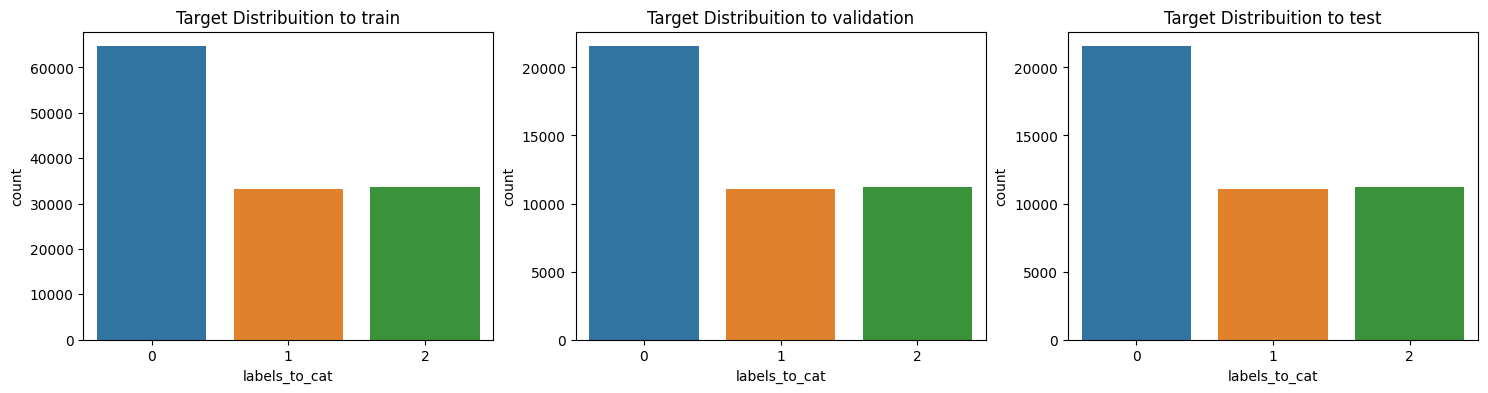

In [18]:
print("Training data shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("Validation data shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

print("Testing data shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

fig, ax = plt.subplots(1,3, figsize=(18,4))
ax[0].set_title('Target Distribuition to train')
sns.countplot(ax=ax[0], x=y_train)
ax[1].set_title('Target Distribuition to validation')
sns.countplot(ax=ax[1], x=y_val)
ax[2].set_title('Target Distribuition to test')
sns.countplot(ax=ax[2], x=y_test)

When working with natural language processing (NLP) tasks and neural networks, it's common to preprocess text data using tokenization, converting text to sequences, and padding sequences. These steps are crucial for preparing text data for input into neural networks. Let's go through each step:

* Tokenizer: Tokenization is the process of breaking down text into individual words or subwords, called tokens. It helps in converting raw text data into a format suitable for further processing.

* Text to Sequence: After fitting the tokenizer, you can use it to convert the text data into sequences of integers. Each word in the text is replaced by its corresponding integer value from the word index.

* Pad Sequences: Neural networks typically require input data of consistent length, but texts can have varying lengths of words. To address this, we pad the sequences, which means adding zeros (or any other value) to the sequences to make them all the same length.

In [19]:
# Parameters
vocab_size = 8000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the validation sequences
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,maxlen=max_length)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

tonekizer_config = tokenizer.to_json()
with open('../database/tokenizer_config.json', 'w') as f:
    json.dump(tonekizer_config, f)

Creating a model with LSTM (Long Short-Term Memory) and attention mechanism involves combining these two components to leverage the power of LSTM's sequential learning and attention's ability to focus on important parts of the input sequence.

In [21]:
embedding_dim = 64
lstm_dim = 128
dense_dim = 3

# Model Definition with LSTM and Attentions
def create_model(max_length, vocab_size,  embedding_dim, lstm_dim, dense_dim):
    sequence_input = Input(shape=(max_length,))
    embedded_sequences = Embedding(vocab_size, embedding_dim)(sequence_input)
    lstm = LSTM(lstm_dim,return_sequences=True,dropout=0.2, activation='tanh')(embedded_sequences)
    lstm_02 = LSTM(lstm_dim,return_sequences=True,dropout=0.2, activation='tanh')(lstm)
    atte_layer=AttentionMecanism()(lstm_02)
    output = Dense(dense_dim, activation="softmax")(atte_layer)
    
    # Create and compile the model
    model = tf.keras.Model(inputs=sequence_input, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

model = create_model(max_length, vocab_size,  embedding_dim, lstm_dim, dense_dim)
# Print the model summary
model.summary()

2023-07-26 17:17:13.736308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 17:17:14.337662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 17:17:14.337958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding (Embedding)       (None, 120, 64)           512000    
                                                                 
 lstm (LSTM)                 (None, 120, 128)          98816     
                                                                 
 lstm_1 (LSTM)               (None, 120, 128)          131584    
                                                                 
 attention_mecanism (Attenti  (None, 128)              32896     
 onMecanism)                                                     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                             

To train your model with early stopping, you can use the EarlyStopping callback in TensorFlow/Keras. This callback will monitor a chosen validation metric during training and stop the training process if the metric does not improve for a certain number of epochs (patience)

In [22]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

#Earlying stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
# Train the model
history_lstm = model.fit(padded, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(val_padded, y_val), callbacks=[callback])

Epoch 1/10


2023-07-26 17:17:28.808392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-26 17:17:28.809341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-26 17:17:28.809976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1028/1028 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.8107

2023-07-26 17:18:23.422120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-26 17:18:23.422976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-26 17:18:23.423574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1028/1028 [==============================] - 57s 40ms/step - loss: 0.4816 - accuracy: 0.8107 - val_loss: 0.3322 - val_accuracy: 0.8822
Epoch 2/10
1028/1028 [==============================] - 19s 18ms/step - loss: 0.2992 - accuracy: 0.8940 - val_loss: 0.2960 - val_accuracy: 0.8967
Epoch 3/10
1028/1028 [==============================] - 18s 17ms/step - loss: 0.2723 - accuracy: 0.9042 - val_loss: 0.2809 - val_accuracy: 0.9024
Epoch 4/10
1028/1028 [==============================] - 18s 17ms/step - loss: 0.2502 - accuracy: 0.9122 - val_loss: 0.2742 - val_accuracy: 0.9040
Epoch 5/10
1028/1028 [==============================] - 18s 17ms/step - loss: 0.2308 - accuracy: 0.9187 - val_loss: 0.2766 - val_accuracy: 0.9064


Detecting overfitting in TensorFlow involves monitoring the performance of your model during both training and validation phases. Here are some common techniques to detect overfitting. 

* Plot Training and Validation Loss Curves:
During training, keep track of the training and validation loss for each epoch and plot them on a graph. Overfitting occurs when the training loss keeps decreasing, but the validation loss starts to increase or stagnate. If you observe a significant gap between training and validation loss, it indicates overfitting.

* Plot Training and Validation Accuracy Curves:
Similarly, you can plot the training and validation accuracy curves to detect overfitting.


In [23]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

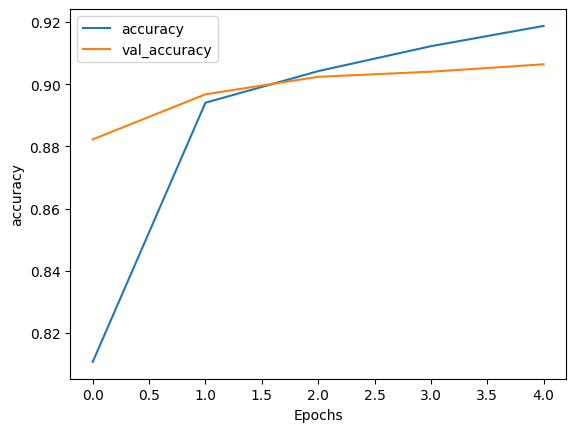

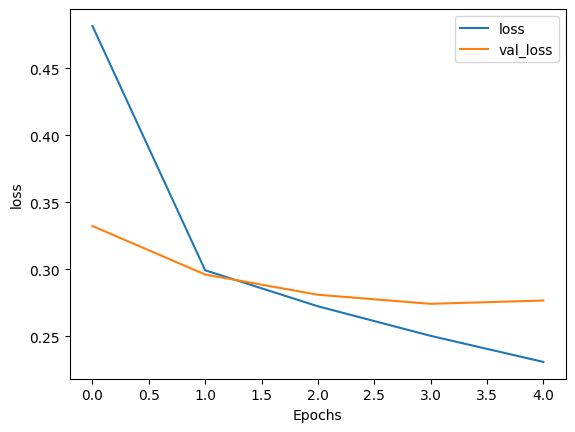

In [24]:
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In TensorFlow, you can use the trained model to make predictions on new data using the model.predict() method. For multiclass classification tasks, we use tf.argmax() to obtain the class labels by selecting the index of the highest probability for each sample. After, we compared the result predictions to real label using confusion matrix. The confusion matrix is a tabular representation that allows us to evaluate the performance of a classification model. It compares the actual labels of a dataset with the predicted labels generated by the model. In a confusion matrix, the rows represent the actual classes, and the columns represent the predicted classes. Lastly, we plot the classification report, a summary of various performance metrics for a classification model. It provides a more comprehensive evaluation than the confusion matrix, as it includes metrics such as precision, recall (also known as sensitivity or true positive rate), F1-score, and support for each class in the multiclass classification problem.

In [25]:
predict = model.predict(testing_padded)
y_predict = [p.argmax() for p in predict]

2023-07-26 17:22:41.720270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-26 17:22:41.721118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-26 17:22:41.721730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1371/1371 [==============================] - 6s 4ms/step


<Axes: >

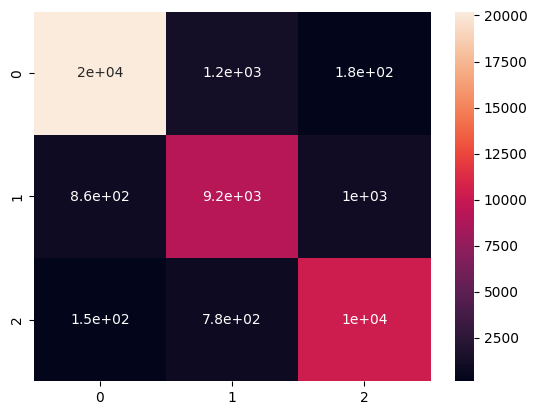

In [26]:
conf_matrix = tf.math.confusion_matrix(y_test, y_predict)
conf_matrix = conf_matrix.numpy()
sns.heatmap(conf_matrix, annot=True)

In [27]:
target_names = ['Bad', 'Neutral', 'Positive']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

         Bad       0.95      0.94      0.94     21559
     Neutral       0.82      0.83      0.83     11098
    Positive       0.89      0.92      0.91     11202

    accuracy                           0.90     43859
   macro avg       0.89      0.89      0.89     43859
weighted avg       0.90      0.90      0.90     43859



TensorFlow allows you to save the entire model architecture, including the model's architecture, weights, optimizer state, and training configuration. This allows you to later load the model and resume training or use it for inference without needing to retrain it. n TensorFlow, you can save and load just the weights of a model using the save_weights and load_weights methods of the model object. This is useful when you want to save and restore the model's learned parameters (weights) without saving the entire model architecture and optimizer state. The to_json() method in TensorFlow/Keras is used to convert the model architecture (model's configuration) to a JSON format. This JSON representation allows you to save only the model's architecture and later recreate the model using the model_from_json() function.

In [28]:
path_structure = "../model/model_structure.json"
path_weights = "../model/model_weights.h5"
# serialize model to JSON
model_json = model.to_json()
with open(path_structure, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(path_weights)